In [2]:
import yfinance as yf

/Users/williamcheng/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
tmf = yf.Ticker("TMF") #get the data on TMF

In [4]:
tmf = tmf.history(period="max") #get all time data on TMF

In [5]:
tmf

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2009-04-16 00:00:00-04:00,106.956245,108.144242,105.951017,106.261726,4560,0.0,0.0,0.0
2009-04-17 00:00:00-04:00,104.543683,104.726452,100.906582,101.509727,12040,0.0,0.0,0.0
2009-04-20 00:00:00-04:00,104.470599,107.669052,104.470599,107.669052,2720,0.0,0.0,0.0
2009-04-21 00:00:00-04:00,110.410543,111.434054,104.379177,104.415733,6240,0.0,0.0,0.0
2009-04-22 00:00:00-04:00,104.360914,104.360914,99.608928,100.851753,10120,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2024-06-14 00:00:00-04:00,53.570000,54.279999,53.290001,53.980000,6863100,0.0,0.0,0.0
2024-06-17 00:00:00-04:00,52.049999,52.520000,51.599998,52.299999,6033600,0.0,0.0,0.0
2024-06-18 00:00:00-04:00,52.630001,53.799999,52.340000,53.750000,5541300,0.0,0.0,0.0


In [6]:
del tmf["Dividends"] #remove dividends and stock splits, unneeded
del tmf["Stock Splits"]

<Axes: xlabel='Date'>

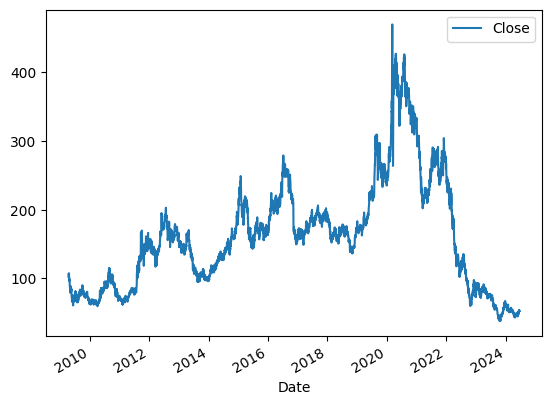

In [7]:
tmf.plot.line(y="Close", use_index=True) #plot the closing values of TMF

In [8]:
tmf["Tomorrow"] = tmf["Close"].shift(-1) #create a "tomorrow" column by taking the close value and shifting it back 1 row

In [9]:
del tmf["Capital Gains"] #delete Capital Gains, unneeded

In [10]:
tmf["Target"] = (tmf["Tomorrow"] > tmf["Close"]).astype(int) #create "Target", that is either 0 or 1 depending on whether Tomorrow's price is higher than Today's close

In [12]:
from sklearn.metrics import precision_score #import to test the accuracy of our predictions

In [13]:
import pandas as pd

In [14]:
def predict(test, predictors, train, model): #build an function for the testing of the model
        model.fit(train[predictors], train["Target"])
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index = test.index, name="Predictions")
        combined = pd.concat([test["Target"], preds], axis=1)
        return combined


In [15]:
def backtest(data, model, predictors, start=2500, step=250): #backtesting: start at ten years time seeing ten years of historical data; step one year at a time
        all_predictions = [] #predictions for each year (step) is stored here

        for i in range(start, data.shape[0], step): #loop from 2500 to the end of the dataset, increasing i by 250 each time
                train = data.iloc[0:i].copy() #train from first entry to start entry (train with all years prior to current year)
                test = data.iloc[i:(i+step)].copy() #predict from start entry to start+step (predict upcoming year
                predictions = predict(test, predictors, train, model) #use prediction function to predict year
                all_predictions.append(predictions) #add the predictions for the current year to all_predictions
        return pd.concat(all_predictions) #takes the list of all predictions and combines them into one



In [19]:
interest_rates = pd.read_csv('./FEDFUNDS.csv', parse_dates=["DATE"], index_col=["DATE"])
interest_rates.index #adding federal reserve rates to predict TMF
tmf = tmf.tz_localize(None)
tmf["interest"] = pd.Series(dtype='float64')

for i in range(0, tmf.shape[0]):
        if (tmf.index[i].strftime('%Y-%m') + '-01' == '2024-06-01'):
                tmf.at[tmf.index[i], "interest"] = float(5.33)
        else:
                tmf.at[tmf.index[i], "interest"] = interest_rates.at[tmf.index[i].strftime('%Y-%m') + '-01', "FEDFUNDS"]
tmf

,Open,High,Low,Close,Volume,Tomorrow,Target,interest
Date,,,,,,,,
2009-04-16,106.956245,108.144242,105.951017,106.261726,4560,101.509727,0,0.15
2009-04-17,104.543683,104.726452,100.906582,101.509727,12040,107.669052,1,0.15
2009-04-20,104.470599,107.669052,104.470599,107.669052,2720,104.415733,0,0.15
2009-04-21,110.410543,111.434054,104.379177,104.415733,6240,100.851753,0,0.15
2009-04-22,104.360914,104.360914,99.608928,100.851753,10120,101.381767,1,0.15
...,...,...,...,...,...,...,...,...
2024-06-14,53.570000,54.279999,53.290001,53.980000,6863100,52.299999,0,5.33
2024-06-17,52.049999,52.520000,51.599998,52.299999,6033600,53.750000,1,5.33
2024-06-18,52.630001,53.799999,52.340000,53.750000,5541300,52.660000,0,5.33


In [20]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=2000, min_samples_split=500, random_state=1) #update RFC to have more estimators and less split

In [17]:
def predict(test, predictors, train, model): #build an function for the testing of the model
        model.fit(train[predictors], train["Target"])
        preds = model.predict_proba(test[predictors])[:,1] #instead of returning 0 or 1, the prediction will return the probability of it being either 0 or 1 (with .predict_proba), and then get the second item in the array which is the probability of it going up
        preds[preds >= .6] = 1 #only predict that the stock goes up if the probability of it going up is over 60%
        preds[preds < .6] = 0 #otherwise predict that the stock goes down
        preds = pd.Series(preds, index = test.index, name="Predictions")
        combined = pd.concat([test["Target"], preds], axis=1)
        return combined


In [22]:
tmf["Interest_Tomorrow"] = tmf["interest"].shift(-1) #create a "tomorrow" column by taking the close value and shifting it back 1 row
tmf["Interest_Target"] = (tmf["Interest_Tomorrow"] > tmf["interest"]).astype(int) #create "Target", that is either 0 or 1 depending on whether Tomorrow's price is higher than Today's close
tmf

,Open,High,Low,Close,Volume,Tomorrow,Target,interest,Interest_Tomorrow,Interest_Target
Date,,,,,,,,,,
2009-04-16,106.956245,108.144242,105.951017,106.261726,4560,101.509727,0,0.15,0.15,0
2009-04-17,104.543683,104.726452,100.906582,101.509727,12040,107.669052,1,0.15,0.15,0
2009-04-20,104.470599,107.669052,104.470599,107.669052,2720,104.415733,0,0.15,0.15,0
2009-04-21,110.410543,111.434054,104.379177,104.415733,6240,100.851753,0,0.15,0.15,0
2009-04-22,104.360914,104.360914,99.608928,100.851753,10120,101.381767,1,0.15,0.15,0
...,...,...,...,...,...,...,...,...,...,...
2024-06-14,53.570000,54.279999,53.290001,53.980000,6863100,52.299999,0,5.33,5.33,0
2024-06-17,52.049999,52.520000,51.599998,52.299999,6033600,53.750000,1,5.33,5.33,0
2024-06-18,52.630001,53.799999,52.340000,53.750000,5541300,52.660000,0,5.33,5.33,0


In [23]:
horizons = [2, 5, 60, 250, 1000] #adding rolling mean close for the previous 2 days, week, three months, year, and four years
#use the ratio between the closing price now and the closing price then to make predictions
new_predictors = [] #to store the new rolling means

for horizon in horizons: #loop through the data in horizions, and calculate a rolling average for each time window
        rolling_averages = tmf.rolling(horizon).mean()

        ratio_column = f"Close_Ratio_{horizon}"
        tmf[ratio_column] = tmf["Close"] / rolling_averages["Close"] #close price of the day / rolling avergage of "horizon" days

        trend_column = f"Trend_{horizon}" #the number of days in the past "horizon" days that the stock went up
        tmf[trend_column] = tmf.shift(1).rolling(horizon).sum()["Target"] #getting the sum of the target from the past "horizion" days

        interest_ratio = f"Interest_Ratio_{horizon}"
        tmf[interest_ratio] = tmf["Close"] / rolling_averages["interest"]

        interest_trend = f"Interest_Trend_{horizon}"
        tmf[interest_trend] = tmf.shift(1).rolling(horizon).sum()["Interest_Target"]

        new_predictors += [ratio_column, trend_column, interest_ratio, interest_trend]

In [24]:
tmf

,Open,High,Low,Close,Volume,Tomorrow,Target,interest,Interest_Tomorrow,Interest_Target,...,Interest_Ratio_60,Interest_Trend_60,Close_Ratio_250,Trend_250,Interest_Ratio_250,Interest_Trend_250,Close_Ratio_1000,Trend_1000,Interest_Ratio_1000,Interest_Trend_1000
Date,,,,,,,,,,,,,,,,,,,,,
2009-04-16,106.956245,108.144242,105.951017,106.261726,4560,101.509727,0,0.15,0.15,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-17,104.543683,104.726452,100.906582,101.509727,12040,107.669052,1,0.15,0.15,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-20,104.470599,107.669052,104.470599,107.669052,2720,104.415733,0,0.15,0.15,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-21,110.410543,111.434054,104.379177,104.415733,6240,100.851753,0,0.15,0.15,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-22,104.360914,104.360914,99.608928,100.851753,10120,101.381767,1,0.15,0.15,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14,53.570000,54.279999,53.290001,53.980000,6863100,52.299999,0,5.33,5.33,0,...,10.127580,0.0,0.988618,121.0,10.176841,2.0,0.320184,478.0,23.170465,22.0
2024-06-17,52.049999,52.520000,51.599998,52.299999,6033600,53.750000,1,5.33,5.33,0,...,9.812383,0.0,0.959591,120.0,9.858252,2.0,0.310800,477.0,22.398862,22.0
2024-06-18,52.630001,53.799999,52.340000,53.750000,5541300,52.660000,0,5.33,5.33,0,...,10.084428,0.0,0.987942,120.0,10.129660,2.0,0.320036,477.0,22.968221,22.0


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

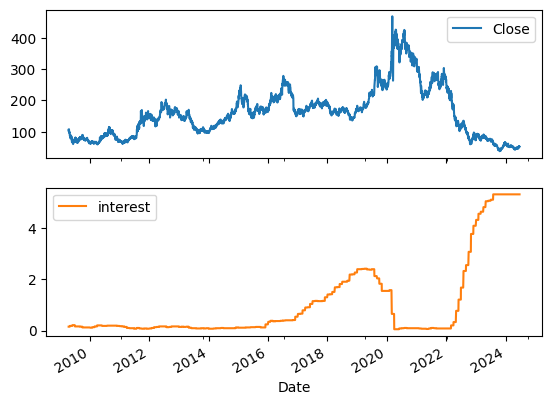

In [25]:
tmf.plot.line(y=["Close", "interest"], use_index=True, subplots=True) #plot the closing values of TMF

In [26]:
droppedna_tmf = tmf.dropna().copy()

In [27]:
droppedna_tmf

,Open,High,Low,Close,Volume,Tomorrow,Target,interest,Interest_Tomorrow,Interest_Target,...,Interest_Ratio_60,Interest_Trend_60,Close_Ratio_250,Trend_250,Interest_Ratio_250,Interest_Trend_250,Close_Ratio_1000,Trend_1000,Interest_Ratio_1000,Interest_Trend_1000
Date,,,,,,,,,,,,,,,,,,,,,
2013-04-08,164.397970,165.364893,160.991783,161.541168,39800,160.222641,0,0.15,0.15,0,...,1120.516774,2.0,1.001782,132.0,1075.793608,5.0,1.482654,526.0,1139.138059,17.0
2013-04-09,161.760919,162.595995,159.475485,160.222641,14320,153.608017,0,0.15,0.15,0,...,1110.087582,2.0,0.992998,131.0,1066.728635,5.0,1.469760,526.0,1129.840216,17.0
2013-04-10,156.245064,156.948280,153.608017,153.608017,31720,154.333191,1,0.15,0.15,0,...,1063.031259,2.0,0.951683,130.0,1022.417578,5.0,1.408489,525.0,1083.195945,17.0
2013-04-11,154.684805,155.607761,153.915666,154.333191,24840,161.211517,1,0.15,0.15,0,...,1066.819292,2.0,0.955721,131.0,1026.970927,5.0,1.414491,526.0,1088.309646,17.0
2013-04-12,159.101884,161.409301,157.409776,161.211517,30240,165.254990,1,0.15,0.15,0,...,1113.082974,2.0,0.997632,132.0,1072.455544,5.0,1.476715,527.0,1136.813464,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-13,51.630001,52.889999,51.180000,52.680000,8081000,53.980000,1,5.33,5.33,0,...,9.883677,0.0,0.963274,120.0,9.933625,2.0,0.311898,478.0,22.663523,22.0
2024-06-14,53.570000,54.279999,53.290001,53.980000,6863100,52.299999,0,5.33,5.33,0,...,10.127580,0.0,0.988618,121.0,10.176841,2.0,0.320184,478.0,23.170465,22.0
2024-06-17,52.049999,52.520000,51.599998,52.299999,6033600,53.750000,1,5.33,5.33,0,...,9.812383,0.0,0.959591,120.0,9.858252,2.0,0.310800,477.0,22.398862,22.0


In [29]:
new_predictors

['Close_Ratio_2',
 'Trend_2',
 'Interest_Ratio_2',
 'Interest_Trend_2',
 'Close_Ratio_5',
 'Trend_5',
 'Interest_Ratio_5',
 'Interest_Trend_5',
 'Close_Ratio_60',
 'Trend_60',
 'Interest_Ratio_60',
 'Interest_Trend_60',
 'Close_Ratio_250',
 'Trend_250',
 'Interest_Ratio_250',
 'Interest_Trend_250',
 'Close_Ratio_1000',
 'Trend_1000',
 'Interest_Ratio_1000',
 'Interest_Trend_1000']

In [28]:
predictions = backtest(droppedna_tmf, model, new_predictors) #getting rid of original predictors (open, close, volume, high low) because an absolute value does little to predict trends

In [30]:
predictions["Predictions"].value_counts()

Predictions
0.0    295
1.0     26
Name: count, dtype: int64

In [31]:
precision_score(predictions["Target"], predictions["Predictions"])

np.float64(0.5769230769230769)

In [237]:
no_interest_predictors = ['Close_Ratio_2',
 'Trend_2',
 'Close_Ratio_5',
 'Trend_5',
 'Close_Ratio_60',
 'Trend_60',
 'Close_Ratio_250',
 'Trend_250',
 'Close_Ratio_1000',
 'Trend_1000']

In [238]:
predictions = backtest(droppedna_tmf, model, no_interest_predictors) #getting rid of original predictors (open, close, volume, high low) because an absolute value does little to predict trends

In [239]:
predictions["Predictions"].value_counts()

Predictions
0.0    310
1.0     11
Name: count, dtype: int64

In [240]:
precision_score(predictions["Target"], predictions["Predictions"])

np.float64(0.5454545454545454)

In [243]:
tmf

,Open,High,Low,Close,Volume,Tomorrow,Target,interest,Close_Ratio_2,Trend_2,...,Interest_Ratio_5,Close_Ratio_60,Trend_60,Interest_Ratio_60,Close_Ratio_250,Trend_250,Interest_Ratio_250,Close_Ratio_1000,Trend_1000,Interest_Ratio_1000
Date,,,,,,,,,,,,,,,,,,,,,
2009-04-16,106.956261,108.144257,105.951033,106.261742,4560,101.509743,0,0.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-17,104.543699,104.726467,100.906597,101.509743,12040,107.669037,1,0.15,0.977129,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-20,104.470585,107.669037,104.470585,107.669037,2720,104.415741,0,0.15,1.029445,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-21,110.410551,111.434062,104.379185,104.415741,6240,100.851768,0,0.15,0.984660,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-22,104.360930,104.360930,99.608944,100.851768,10120,101.381783,1,0.15,0.982637,0.0,...,672.345123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14,53.570000,54.279999,53.290001,53.980000,6863100,52.299999,0,5.33,1.012188,2.0,...,10.127580,1.113671,32.0,10.127580,0.988618,121.0,10.176841,0.320184,478.0,23.170465
2024-06-17,52.049999,52.520000,51.599998,52.299999,6033600,53.750000,1,5.33,0.984193,1.0,...,9.812383,1.078936,31.0,9.812383,0.959591,120.0,9.858252,0.310800,477.0,22.398862
2024-06-18,52.630001,53.799999,52.340000,53.750000,5541300,52.660000,0,5.33,1.013673,1.0,...,10.084428,1.108777,31.0,10.084428,0.987942,120.0,10.129660,0.320036,477.0,22.968221
